# 1. Import packages

In [1]:
import os
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import logging 

In [2]:
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

# 2. Data loading

## 2.1. Dataset description

### A toy dataset for now
#### G-10 currency pairs. Every curreny other than USD is against USD. So we have 9 pairs in total
- gbpusd, usdsek, usdnok, usdjpy, usdcad, usdchf, nzdusd, eurusd, audusd

#### Period in use: May 2019 (1 month)

## 2.2 Loading a toy data set

In [3]:
toy_path = '../dataset/'
toy_folders = ['toyset']

# csv files have no explicit column header, but column names come in this order.
# 'timestamp',  'opening', 'high', 'low', 'close', 'volume'
# As we are only interested in timestamp and close prices, we set `usecols` = [0,4], a list of indices
col_names = ['datetime',  'opening', 'high', 'low', 'close', 'volume']
usecols = [0, 2, 3]

df = {}
f = pd.DataFrame(columns=col_names)
total_size = 0
logger.info("Loading...")
for folder in toy_folders:
    files = os.listdir(toy_path+folder)
    for file in files:
        if file.endswith(".csv"):
            logger.info(file)
            tmp = pd.read_csv(os.path.join(toy_path, folder, file),
                              delimiter=';', header=0, names=col_names, usecols=usecols)
            loaded_ccy = file[:6]
            if loaded_ccy in df.keys():
                df[loaded_ccy] = df[loaded_ccy].append(tmp, ignore_index=True)
            else:
                df[loaded_ccy] = tmp.copy()
            total_size += len(tmp)
logger.info("Complted.")

INFO: Loading...
INFO: nzdusd_DAT_ASCII_NZDUSD_M1_201904.csv
INFO: nzdusd_DAT_ASCII_NZDUSD_M1_201905.csv
INFO: nzdusd_DAT_ASCII_NZDUSD_M1_201901.csv
INFO: nzdusd_DAT_ASCII_NZDUSD_M1_201902.csv
INFO: nzdusd_DAT_ASCII_NZDUSD_M1_201903.csv
INFO: usdchf_DAT_ASCII_USDCHF_M1_201903.csv
INFO: usdchf_DAT_ASCII_USDCHF_M1_201902.csv
INFO: usdchf_DAT_ASCII_USDCHF_M1_201901.csv
INFO: usdchf_DAT_ASCII_USDCHF_M1_201905.csv
INFO: usdchf_DAT_ASCII_USDCHF_M1_201904.csv
INFO: gbpusd_DAT_ASCII_GBPUSD_M1_201904.csv
INFO: usdnok_DAT_ASCII_USDNOK_M1_201905.csv
INFO: usdsek_DAT_ASCII_USDSEK_M1_201902.csv
INFO: usdsek_DAT_ASCII_USDSEK_M1_201903.csv
INFO: usdnok_DAT_ASCII_USDNOK_M1_201904.csv
INFO: gbpusd_DAT_ASCII_GBPUSD_M1_201905.csv
INFO: usdsek_DAT_ASCII_USDSEK_M1_201901.csv
INFO: gbpusd_DAT_ASCII_GBPUSD_M1_201902.csv
INFO: usdnok_DAT_ASCII_USDNOK_M1_201903.csv
INFO: usdsek_DAT_ASCII_USDSEK_M1_201904.csv
INFO: usdsek_DAT_ASCII_USDSEK_M1_201905.csv
INFO: usdnok_DAT_ASCII_USDNOK_M1_201902.csv
INFO: gbpusd_DA

In [4]:
print('We have {:d} data points in total for all pairs'.format(total_size))

We have 1390011 data points in total for all pairs


In [5]:
df.keys()

dict_keys(['nzdusd', 'usdchf', 'gbpusd', 'usdnok', 'usdsek', 'audusd', 'eurusd', 'usdcad', 'usdjpy'])

In [6]:
ccy_list = list(df.keys())
print('We have a list of currency pairs:', ccy_list)

We have a list of currency pairs: ['nzdusd', 'usdchf', 'gbpusd', 'usdnok', 'usdsek', 'audusd', 'eurusd', 'usdcad', 'usdjpy']


In [7]:
print('e.g.', ccy_list[0])
df[ccy_list[0]].head()

e.g. nzdusd


,datetime,high,low
0,20190401 000100,0.68248,0.68238
1,20190401 000200,0.68261,0.68239
2,20190401 000300,0.68272,0.68257
3,20190401 000400,0.68276,0.68259
4,20190401 000500,0.68270,0.68261


#### We do not have ask prices in our data set.
- We take high prices as `ask_price` and low prices as `bid_price` for now just until we have a new data set.

In [8]:
df['eurusd'].columns

Index(['datetime', 'high', 'low'], dtype='object')

In [9]:
for ccy in ccy_list:
    df[ccy].rename(columns={'high': 'ask_price', 'low': 'bid_price'}, inplace=True)

## 2.3 Data Integrity Check

In [10]:
for i, ccy in enumerate(ccy_list):
    desc = df[ccy].describe()
    desc.rename(columns={'ask_price': ccy+'_ask', 'bid_price':ccy+'_bid'}, inplace=True)
    if i == 0:
        df_desc = desc.copy()
    else:
        df_desc = pd.merge(df_desc, desc, left_index=True, right_index=True)

- Outliers: none.
- Index: The number of data points a little vary. See the **2.5 `timestamp` policy** to handle this.

In [11]:
df_desc

,nzdusd_ask,nzdusd_bid,usdchf_ask,usdchf_bid,gbpusd_ask,gbpusd_bid,usdnok_ask,usdnok_bid,usdsek_ask,usdsek_bid,audusd_ask,audusd_bid,eurusd_ask,eurusd_bid,usdcad_ask,usdcad_bid,usdjpy_ask,usdjpy_bid
count,154460.000000,154460.000000,153905.000000,153905.000000,154609.000000,154609.000000,154650.000000,154650.000000,153648.000000,153648.000000,154587.000000,154587.000000,154673.000000,154673.000000,154521.000000,154521.000000,154958.000000,154958.000000
mean,0.674211,0.674117,1.002077,1.001983,1.299031,1.298826,8.608601,8.607294,9.290274,9.288836,0.708465,0.708362,1.129856,1.129738,1.334558,1.334419,110.418996,110.407525
std,0.011425,0.011415,0.009914,0.009925,0.017675,0.017658,0.095264,0.095219,0.210172,0.210253,0.009088,0.009085,0.009650,0.009635,0.010762,0.010760,1.109443,1.112565
min,0.648210,0.648130,0.971690,0.971580,1.246080,1.242500,8.400640,8.399150,8.851560,8.849790,0.673740,0.672180,1.111240,1.110700,1.307010,1.306820,105.390000,104.736000
25%,0.666320,0.666250,0.995830,0.995730,1.287890,1.287660,8.536650,8.535300,9.170620,9.169358,0.703050,0.702940,1.121850,1.121760,1.327050,1.326900,109.602000,109.591000
50%,0.676390,0.676290,1.001380,1.001290,1.303080,1.302840,8.595650,8.594250,9.278640,9.277230,0.710000,0.709900,1.129910,1.129800,1.334900,1.334770,110.550000,110.540000
75%,0.683220,0.683130,1.008410,1.008340,1.310920,1.310650,8.683010,8.681747,9.440400,9.438785,0.714890,0.714810,1.136680,1.136560,1.343390,1.343270,111.418000,111.409000
max,0.694140,0.693850,1.023630,1.022830,1.338080,1.335170,8.819380,8.816520,9.687630,9.686170,0.729480,0.729180,1.156970,1.156890,1.366220,1.365540,112.399000,112.395000


In [12]:
max_datapoints = np.max(df_desc.loc['count'])
max_datapoints

154958.0

## 2.4 Drop from and add some columns to `df`

- Drop: `datetime` (no use)
- Add: `ccy`, `timestamp`
- Retain: `bid_price`, `ask_price`

In [13]:
for ccy in ccy_list:
    df[ccy]['ccy'] = ccy
    df[ccy]['timestamp'] = df[ccy].datetime.apply(lambda x: pd.to_datetime(x))
    cols_to_use = ['timestamp', 'ccy', 'bid_price', 'ask_price']
    df[ccy] = df[ccy][cols_to_use]

In [14]:
#rand_ccy = ccy_list[np.random.randint(len(ccy_list))]
rand_ccy='usdjpy'
df[rand_ccy].sample(5)

,timestamp,ccy,bid_price,ask_price
7368,2019-04-08 03:08:00,usdjpy,111.453,111.459
90180,2019-01-27 20:50:00,usdjpy,109.404,109.420
101416,2019-02-06 16:14:00,usdjpy,109.965,109.966
72734,2019-01-09 17:46:00,usdjpy,108.148,108.155
81947,2019-01-18 03:26:00,usdjpy,109.420,109.430


### Check if we have all data points in `df`

In [15]:
assert np.sum([len(df[ccy]) for ccy in ccy_list]) == total_size, "We got some data loss."

## 2.5 Padding missing time to `df`

### Creating a new index `idx`
#### `timestamp` policy:
- If any curency pair has any price at timestamp $t$, then we have the timestamp $t$ for the rest of the currency pairs as well.

#### We create a union set `idx` of `timestamp` for every currency pair so that we can cover every data point.

In [16]:
ccy_idx = {}
for i, ccy in enumerate(ccy_list):
    ccy_idx[ccy] = pd.Index(df[ccy].timestamp)
    if i == 0 :
        idx = pd.Index(ccy_idx[ccy])
    else:
        idx = idx.union(ccy_idx[ccy])

In [17]:
assert len(idx) >= np.max([len(ccy_idx[key]) for key in ccy_idx.keys()]), "len(Union(every index)) must be larger than max(len(indices))"

In [18]:
print('We have {} rows per currency pair'.format(len(idx)))

We have 155265 rows per currency pair


#### Apply `idx` to every `df[ccy]`

In [19]:
for ccy in ccy_list:
    df_ccy = pd.DataFrame(index=idx)
    df[ccy] = df_ccy.merge(df[ccy], how='left', on='timestamp')
    df[ccy]['ccy'].fillna(ccy, inplace=True)

In [20]:
assert [ len(idx) == len(df[key]) for key in df.keys()], "Some df[ccy] have the different number of rows."

In [21]:
assert np.min([df[f].shape[0] for f in df.keys()]) >= max_datapoints, "We got some data loss."

#### We get the global earliest date and last date over the entire data set.

## 2.6 Create the data set `X`
### We do it simply by appending `df` for each currency pair to create the data set `X`

Create a template for `X`

In [22]:
X = pd.DataFrame(columns = df[ccy_list[0]].columns)
X

,timestamp,ccy,bid_price,ask_price


In [23]:
for ccy in ccy_list:
    X = X.append(df[ccy], ignore_index=False, sort=False)

In [24]:
X.sample(5)

,timestamp,ccy,bid_price,ask_price
104444,2019-04-12 06:57:00,usdnok,8.49635,8.49869
1469,2019-01-02 17:30:00,usdcad,1.35923,1.35995
58869,2019-02-27 14:18:00,nzdusd,0.68363,0.68373
30747,2019-01-31 01:34:00,gbpusd,1.31237,1.31247
82301,2019-03-21 19:52:00,gbpusd,1.31215,1.31226


In [25]:
assert X.shape[0] == len(ccy_list)*len(idx), "We have some data loss."

## 2.7 Missing Data Analysis
#### An imputing policy:
- First we sort `X` by `ccy` and `timestamp`, and reset the index.
- Then we group `X` by `ccy`
- We finally forwardfill (use previous values to fill missing values)

In [26]:
X = X.sort_values(by=['ccy','timestamp'])
X.reset_index(drop=True, inplace=True)

### Missing data
- `bid_price`: see a number below
- `ask_price`: see a number below
- We impute them by previous values (done by group)

In [27]:
X.isna().sum()

timestamp       0
ccy             0
bid_price    7374
ask_price    7374
dtype: int64

In [28]:
g = X.groupby('ccy')
X['bid_price'] = g['bid_price'].fillna(method='ffill')
X['ask_price'] = g['ask_price'].fillna(method='ffill')

#### Sometimes we still have some rows with nan because 'ffill'can't be done due to no previous values.

In [29]:
bid_nan_timestamp = X.loc[X['bid_price'].isna()].timestamp.unique()
ask_nan_timestamp = X.loc[X['ask_price'].isna()].timestamp.unique()
nan_timestamp = np.unique((bid_nan_timestamp,ask_nan_timestamp))

#### We have a list of `timestamp` for a nan row for any currency pair.

In [30]:
nan_timestamp

array(['2019-01-01T17:01:00.000000000', '2019-01-01T17:02:00.000000000',
       '2019-01-01T17:03:00.000000000', '2019-01-01T17:04:00.000000000',
       '2019-01-01T17:05:00.000000000', '2019-01-01T17:06:00.000000000',
       '2019-01-01T17:07:00.000000000', '2019-01-01T17:08:00.000000000',
       '2019-01-01T17:09:00.000000000', '2019-01-01T17:10:00.000000000'],
      dtype='datetime64[ns]')

#### Any row in `nan_timestamp` will be dropped.

In [31]:
X = X[~X['timestamp'].isin(nan_timestamp)]

#### Now we have no missing value. Cleaning is *done*.

In [32]:
X.isna().sum()

timestamp    0
ccy          0
bid_price    0
ask_price    0
dtype: int64

## 2.8 Calculate `bid_ret`, `ask_ret` and `mid_price`

In [36]:
bid_ret = np.log(X['bid_price']) - np.log(X['bid_price'].shift())
ask_ret = np.log(X['ask_price']) - np.log(X['ask_price'].shift())
X.loc[X['ccy'] == X['ccy'].shift(), 'bid_ret'] = bid_ret
X.loc[X['ccy'] == X['ccy'].shift(), 'ask_ret'] = ask_ret
X['mid_price'] = X['ask_price'] - X['bid_price']

/Users/msyeom/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
X_boundary = X.loc[X['ccy'] != X['ccy'].shift()]
X_boundary

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
10,2019-01-01 17:11:00,audusd,0.70464,0.70469,NaN,NaN,0.00005
155275,2019-01-01 17:11:00,eurusd,1.14606,1.14617,NaN,NaN,0.00011
310540,2019-01-01 17:11:00,gbpusd,1.27227,1.27227,NaN,NaN,0.00000
465805,2019-01-01 17:11:00,nzdusd,0.67138,0.67175,NaN,NaN,0.00037
621070,2019-01-01 17:11:00,usdcad,1.36259,1.36289,NaN,NaN,0.00030
776335,2019-01-01 17:11:00,usdchf,0.98061,0.98113,NaN,NaN,0.00052
931600,2019-01-01 17:11:00,usdjpy,109.65200,109.65300,NaN,NaN,0.00100
1086865,2019-01-01 17:11:00,usdnok,8.63465,8.63466,NaN,NaN,0.00001
1242130,2019-01-01 17:11:00,usdsek,8.85770,8.85778,NaN,NaN,0.00008


In [39]:
X.dropna(axis='index', how='any', inplace=True)

/Users/msyeom/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
X.isna().sum()

timestamp    0
ccy          0
bid_price    0
ask_price    0
bid_ret      0
ask_ret      0
mid_price    0
dtype: int64

In [41]:
X.reset_index(drop=True, inplace=True)

In [42]:
X.head()

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
0,2019-01-01 17:12:00,audusd,0.70465,0.70475,0.000014,0.000085,0.00010
1,2019-01-01 17:13:00,audusd,0.70465,0.70471,0.000000,-0.000057,0.00006
2,2019-01-01 17:14:00,audusd,0.70464,0.70472,-0.000014,0.000014,0.00008
3,2019-01-01 17:15:00,audusd,0.70463,0.70473,-0.000014,0.000014,0.00010
4,2019-01-01 17:16:00,audusd,0.70463,0.70469,0.000000,-0.000057,0.00006


## 2.9 Let's plot for a visual check.

In [43]:
# Code: https://stackoverflow.com/questions/11640243/pandas-plot-multiple-y-axes
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    ax.tick_params(axis='y', colors=colors[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)])
        ax_new.set_ylabel(ylabel=cols[n])
        ax_new.tick_params(axis='y', colors=colors[n % len(colors)])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

In [44]:
bid_dict = dict()
ask_dict = dict()
for ccy in ccy_list:
    bid_dict[ccy] = X[X.ccy==ccy].bid_price.reset_index(drop=True)
    ask_dict[ccy] = X[X.ccy==ccy].ask_price.reset_index(drop=True)
X_bid = pd.DataFrame(bid_dict)
X_ask = pd.DataFrame(ask_dict)

In [45]:
X_bid.head()

,nzdusd,usdchf,gbpusd,usdnok,usdsek,audusd,eurusd,usdcad,usdjpy
0,0.67138,0.98061,1.27294,8.63465,8.8577,0.70465,1.14607,1.36280,109.652
1,0.67137,0.98096,1.27294,8.63466,8.8577,0.70465,1.14607,1.36255,109.652
2,0.67138,0.98046,1.27277,8.63465,8.8577,0.70464,1.14607,1.36255,109.623
3,0.67135,0.98045,1.27277,8.63465,8.8577,0.70463,1.14607,1.36255,109.624
4,0.67134,0.98045,1.27277,8.63465,8.8577,0.70463,1.14607,1.36255,109.660


In [46]:
X_ask.head()

,nzdusd,usdchf,gbpusd,usdnok,usdsek,audusd,eurusd,usdcad,usdjpy
0,0.67140,0.98113,1.27294,8.63466,8.85778,0.70475,1.14608,1.36284,109.653
1,0.67139,0.98096,1.27295,8.63466,8.85778,0.70471,1.14608,1.36256,109.653
2,0.67139,0.98098,1.27295,8.63465,8.85778,0.70472,1.14608,1.36255,109.653
3,0.67141,0.98098,1.27277,8.63465,8.85778,0.70473,1.14608,1.36256,109.662
4,0.67139,0.98098,1.27277,8.63465,8.85778,0.70469,1.14608,1.36256,109.668


#### Bid prices

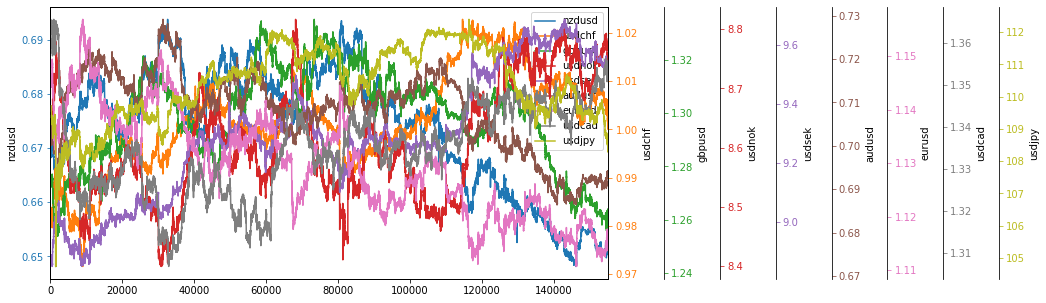

In [47]:
plot_multi(X_bid, figsize=(10, 5))

#### Ask prices

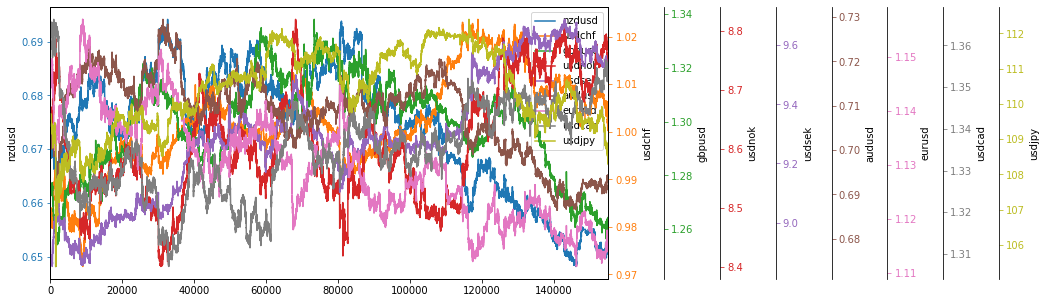

In [48]:
plot_multi(X_ask, figsize=(10, 5))

# 3. Data set `X` is ready

## 3.1 Take a look

In [49]:
X.shape

(1397286, 7)

In [50]:
X.sample(5)

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
1268162,2019-01-27 20:48:00,usdsek,9.03745,9.03868,0.000045,0.000027,0.00123
34146,2019-02-04 10:26:00,audusd,0.72135,0.72146,0.000055,0.000000,0.00011
1243884,2019-01-03 00:04:00,usdsek,9.00477,9.00531,0.000002,0.000001,0.00054
672599,2019-02-20 13:03:00,usdcad,1.31578,1.31601,-0.000061,-0.000175,0.00023
661216,2019-02-08 15:20:00,usdcad,1.32666,1.32678,-0.000038,-0.000023,0.00012


In [51]:
X[X.ccy=='gbpusd'].head(5)

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
310508,2019-01-01 17:12:00,gbpusd,1.27294,1.27294,0.000526,0.000526,0.00000
310509,2019-01-01 17:13:00,gbpusd,1.27294,1.27295,0.000000,0.000008,0.00001
310510,2019-01-01 17:14:00,gbpusd,1.27277,1.27295,-0.000134,0.000000,0.00018
310511,2019-01-01 17:15:00,gbpusd,1.27277,1.27277,0.000000,-0.000141,0.00000
310512,2019-01-01 17:16:00,gbpusd,1.27277,1.27277,0.000000,0.000000,0.00000


## Split: Training set and Validation set(=evaluation set)
- Training set `X_train`: The first two and a half weeks (From May 1, 2019 to May 19, 2019)
- Validation set `X_val`: The following one week (From May 20, 2019 to May 26, 2019)
- Test set `X_test`: The rest of days (From May 27, 2019 to May 31, 2019)
  - In fact, we never create `X_test` until the very last moment.

In [52]:
X_train = X[(X.timestamp >= pd.datetime(2019, 1, 1)) &
            (X.timestamp < pd.datetime(2019, 4, 1))]
X_val = X[(X.timestamp >= pd.datetime(2019, 4, 1)) &
          (X.timestamp < pd.datetime(2019, 5, 1))]

In [53]:
X.drop(X[(X.timestamp >= pd.datetime(2019, 5, 27)) & (
    X.timestamp < pd.datetime(2019, 6, 1))].index, inplace=True)

/Users/msyeom/anaconda3/envs/dl/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [54]:
X.tail()

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
1390502,2019-05-26 23:55:00,usdsek,9.52895,9.52895,0.0,0.0,0.0
1390503,2019-05-26 23:56:00,usdsek,9.52895,9.52895,0.0,0.0,0.0
1390504,2019-05-26 23:57:00,usdsek,9.52895,9.52895,0.0,0.0,0.0
1390505,2019-05-26 23:58:00,usdsek,9.52895,9.52895,0.0,0.0,0.0
1390506,2019-05-26 23:59:00,usdsek,9.52895,9.52895,0.0,0.0,0.0


## 3.2 Save to csv files

In [55]:
X_train.to_csv('../dataset/toy_X_train.csv', index=False)
X_val.to_csv('../dataset/toy_X_val.csv', index=False)

### The end of preprocessing ------------------------------------------------

In [56]:
X_train[X_train.ccy=='usdjpy'].shape, X_train[X_train.ccy=='eurusd'].shape, X_train[X_train.ccy=='gbpusd'].shape

((91057, 7), (91057, 7), (91057, 7))

In [57]:
91057/1460

62.36780821917808

# Dat2019/DRL/run.py

#### Import required packages

In [51]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

# utils
import time

# TensorFlow
import tensorflow as tf
import tensorflow.keras.optimizers as kop
import tensorflow.keras.losses as kls
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

#### Import our packages

In [45]:
from features import draw_episode

#### Configuration
- *Json* format or something else will be used later, but for now...

In [53]:
config = {}
config['lag'] = 20
config['ep_size'] = 100
config['init_lr'] = 0.005
config['momentum'] = 0.9
config['num_of_eval_data'] = 30
config['target_currency'] = 'audusd'
config['epochs'] = 100
config['timespan'] = 1440   # one full day (1440 minutes)

tf.keras.backend.set_floatx('float64')

In [47]:
class Policy(Model):
    def __init__(self):
        super(Policy, self).__init__('mlp_policy')
        self.fc1 = Dense(units=256, activation='relu')
        self.fc2 = Dense(units=64, activation='relu')
        self.value = Dense(1, activation='tanh', name='value')
        
        self.saved_log_probs = []
        self.rewards = 0
#         self.actions = []
        
    def call(self, inputs):
        # `inputs` is a numpy array. We convert to Tensor.
        x = tf.convert_to_tensor(inputs)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.value(x)
        
        return x
    
#     def choose_action(self, obs):
#         # self.call() will be executed under the hool.
#         value = self.predict(obs)
        
#         return np.squeeze(value, axis=-1)

In [48]:
policy = Policy()

In [49]:
def train_eval():
    # We use an optimizer defined in Keras (kop)
    optimizer = kop.SGD(
        learning_rate=config['init_lr'], momentum=config['momentum'], name='SGD')

    # Machine limits for floating point types.
    eps = np.finfo(np.float64).eps.item()
    rewards_over_time = []

    num_of_eval_data = config['num_of_eval_data']
    path = './base/best_model_' + \
        config['target_currency'] + str(time.time()) + '.tf'

    for epoch in range(config['epochs']):
        for ep_idx in range(config['ep_size']):
            prev_action = 0
            # n is `n-th` episode
            # ep_size is a length of one episode.
            # in draw_episode(), X[n:n+ep_size+1] will be used.
            
            # For a lag of 20,
            # feature_span[0] := [20 target's log return(bid prices),
            #                     20 target's log return(ask prices),
            #                     8*20 others' log return(bid prices),
            #                     8*20 others' log return(ask prices)]
            #     at the oldest time stamp.
            # (feature_span[-1] has features at the latest)
            # Features are nomalized within draw_episode()
            target_bid, target_ask, feature_span = \
                draw_episode(X=X_train, cur=config['target_currency'],
                             n=ep_idx, ep_size=config['ep_size'],
                             lag=config['lag'])
            bid, ask, features = target_bid[config['lag']:] * 1e3, \
                            target_ask[config['lag']:]*1e3, \
                            feature_span
            
            # We loop through time stamps in order within an episode.
            for t in range(config['timespan']):
                observation = feature_span[t]
                
                # The neural networks returns an action-like value
                # `state` is a numpy array.
                action_by_nets = policy(observation)
                
                # An actual action to take should effectively cause a trade.
                # Therefore, we subtract `prev_action_by_nets`
                # from `action_by_nets` and take it as our `action`
                action = action_by_nets - prev_action
                print(action, action.shape)
                price = 0
                if action > 0:
                    price = ask[t]  # We buy
                elif action < 0:
                    price = bid[t]  # We sell
                
                # This is an immediate reward caused by taking an action
                reward = tf.math.add(-1*action*price)
                
                # Accumulated rewards
                policy.rewards += reward
                
                prev_action = action_by_nets
            
            # Now that we've completed one episode,
            # we optimize the neural nets.
            losses = policy.train_on_batch(-policy.rewards / config['timespan'])
#             with tf.GradientTape() as tape:
#                 loss = -policy.rewards / config['timespan']
#             grads = tape.gradient(loss, policy.trainable_variables)
#             optimizer.apply_gradient(zip(grads, model.trainable_variables))
            
            if ep_idx % 10 == 0:
                logger.info('Epoch:{} Episode:{}. The training loss is {}'.format(epoch, ep_idx, loss.item()))
            
            policy.rewards = 0

In [54]:
train_eval()

ValueError: Input 0 of layer dense is incompatible with the layer: : expected min_ndim=2, found ndim=1. Full shape received: [360]

# environment.py

In [135]:
import numpy as np
import pandas as pd

In [136]:
class ForexEnv(object):
    '''
    Observation:
        self.timestamp
        self.state =   3 (the day of the week, hour, minute) +
                       3 (the previous position; {-1, 0, 1}) + 
                      20 (the 10-minute bid and ask prices of the target currency) +
                      80 (the 10-minute mid prices of the rest of 8 currency pairs)
                   = 106 (total)
        self.price_record: bid and ask prices of the target currency
        
    Actions:
        -1: short 100%
         0: take a neutral position (no action) and 0 reward. 
        +1: long 100%
        
    Starting State:
        random start within training set.
        i.e., we pick an arbitrary number and take it as index to start with.                 
    '''
    
    def __init__(self, cur='audusd', lag=10, min_history=1440, mode='train'):
        self.ccy = cur
        self.lag = lag
        self.min_history = min_history
        self.index = None
        self.state = None
        self.price_record = None
        self.X_train = X_train
        self.X_val = X.val
        self.trainframe = self.X_train.index.values.tolist()
        self.valframe = self.X_val.index.values.tolist()
        self.train = self.trainframe[:-self.min_history]
        self.val = self.valframe[:-self.min_history]
        self.mode = mode

# experiment.py

In [46]:
import numpy as np

import time

In [47]:
cur ='eurusd'
reward_path = './results/rewards/' + cur + time.strftime("%Y%m%d-%H%M%S") + '/'
agent_path = './results/agents/' + cur + time.strftime("%Y%m%d-%H%M%S") + '/'

if not os.path.exists(reward_path):
    os.makedirs(reward_path)
if not os.path.exists(agent_path):
    os.makedirs(agent_path)


In [131]:
X_train.iloc[10:15]

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
10,2019-05-01 00:12:00,audusd,0.70519,0.70520,0.000014,-0.000028,0.00001
11,2019-05-01 00:13:00,audusd,0.70518,0.70520,-0.000014,0.000000,0.00002
12,2019-05-01 00:14:00,audusd,0.70518,0.70519,0.000000,-0.000014,0.00001
13,2019-05-01 00:15:00,audusd,0.70519,0.70519,0.000014,0.000000,0.00000
14,2019-05-01 00:16:00,audusd,0.70520,0.70521,0.000014,0.000028,0.00001


In [175]:
from features import draw_episode

In [177]:
X_train.shape

(168462, 7)

In [ ]:
draw_episode(X=self.X, cur=self.config['target_currency'],
            n=self.epi_idx, split_sz=self.config['split_sz'],
            lag=self.config['lag'], ts=self.ts, ccy=self.ccy)

In [115]:
target_bid, target_ask, features = draw_episode(
    X, cur='audusd', n=2, ep_size=5, lag=2)

In [116]:
target_bid

array([0.70519, 0.70518, 0.70518, 0.70519, 0.7052 ])

In [117]:
target_bid.shape

(5,)

In [118]:
target_ask

array([0.7052 , 0.7052 , 0.70519, 0.70519, 0.70521])

In [119]:
target_ask.shape

(5,)

In [129]:
features[0]

array([ 0.1184248 , -0.58560619, -0.5855962 , -0.5855962 ,  1.00355167,
        1.44612103,  0.87973326,  1.6410534 ,  0.86520712,  0.86520712,
       -0.62372478,  3.08713404,  1.57963245,  2.55379478, -2.10809715,
       -1.21750035, -0.28469299, -0.28469299,  0.1184248 ,  0.5893887 ,
        0.56097837,  0.1184248 , -0.64285448,  0.1184248 ,  0.86517342,
        1.61193328, -0.25264583,  0.1184248 ,  0.60548446,  1.0925489 ,
       -0.32686362, -0.32686362, -1.14849256, -0.745386  , -0.71883333,
       -0.71883333])

In [121]:
features.shape

(3, 36)

In [122]:
features[0]

array([ 0.1184248 , -0.58560619, -0.5855962 , -0.5855962 ,  1.00355167,
        1.44612103,  0.87973326,  1.6410534 ,  0.86520712,  0.86520712,
       -0.62372478,  3.08713404,  1.57963245,  2.55379478, -2.10809715,
       -1.21750035, -0.28469299, -0.28469299,  0.1184248 ,  0.5893887 ,
        0.56097837,  0.1184248 , -0.64285448,  0.1184248 ,  0.86517342,
        1.61193328, -0.25264583,  0.1184248 ,  0.60548446,  1.0925489 ,
       -0.32686362, -0.32686362, -1.14849256, -0.745386  , -0.71883333,
       -0.71883333])

In [123]:
features[0].shape

(36,)

In [124]:
len(features)

3

In [102]:
np.empty(len(features))

array([-1.28822975e-231,  2.00389893e+000,  2.78113689e-314,
        2.78114481e-314,  2.78114482e-314,  2.12199580e-314,
        0.00000000e+000,  3.95252517e-323,  2.12199579e-314,
        2.76946182e-314,  2.76946163e-314,  2.76946188e-314,
        2.77594478e-314,  2.79264360e-314,  2.79264366e-314,
        2.79264373e-314,  2.79264379e-314,  2.79264385e-314,
        2.79264392e-314,  2.79264398e-314,  2.79264404e-314,
        2.21885319e-314, -1.28822975e-231,  2.00389893e+000,
        2.34573531e-314,  2.21885273e-314,  2.34575557e-314,
        2.21885273e-314,  2.34573147e-314,  2.21885273e-314,
        2.33376200e-314,  2.21885319e-314,  2.34574979e-314,
        2.21885273e-314,  1.29074111e-231, -1.28822975e-231,
        5.92878775e-323,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  2.12199579e-314,  2.12199579e-314,
        0.00000000e+000,

In [103]:
features.shape[1]

180

In [104]:
df['eurusd']

,datetime,high,low
0,20190501 000100,1.12188,1.12182
1,20190501 000200,1.12184,1.12182
2,20190501 000300,1.12183,1.12182
3,20190501 000400,1.12183,1.12182
4,20190501 000500,1.12183,1.12179
5,20190501 000600,1.12181,1.12180
6,20190501 000700,1.12180,1.12179
7,20190501 000800,1.12180,1.12179
8,20190501 000900,1.12180,1.12180
9,20190501 001000,1.12184,1.12182


In [84]:
np.min([df[key].shape[0] for key in df.keys()])

31616

In [85]:
features.shape

(80, 360)

In [133]:
import tensorflow as tf
tf.TypeSpec

tensorflow.python.framework.type_spec.TypeSpec

In [134]:
tf.__version__

'2.0.0'

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
0,2019-05-01 00:02:00,audusd,0.70514,0.70517,0.000000,0.000000,0.00003
1,2019-05-01 00:03:00,audusd,0.70517,0.70517,0.000043,0.000000,0.00000
2,2019-05-01 00:04:00,audusd,0.70517,0.70518,0.000000,0.000014,0.00001
3,2019-05-01 00:05:00,audusd,0.70517,0.70518,0.000000,0.000000,0.00001
4,2019-05-01 00:06:00,audusd,0.70517,0.70518,0.000000,0.000000,0.00001
5,2019-05-01 00:07:00,audusd,0.70517,0.70518,0.000000,0.000000,0.00001
6,2019-05-01 00:08:00,audusd,0.70517,0.70518,0.000000,0.000000,0.00001
7,2019-05-01 00:09:00,audusd,0.70517,0.70518,0.000000,0.000000,0.00001
8,2019-05-01 00:10:00,audusd,0.70517,0.70518,0.000000,0.000000,0.00001
9,2019-05-01 00:11:00,audusd,0.70518,0.70522,0.000014,0.000057,0.00004


In [171]:
cal = X_train[X_train.ccy=='usdjpy'][['bid_price', 'ask_price', 'bid_ret', 'ask_ret']].iloc[500:510].reset_index(drop=True)

In [172]:
cal['bs'] = pd.DataFrame(['B' if i == 0 else 'S' for i in np.random.choice(2, size=10)])

In [174]:
cal.to_csv('t.csv')

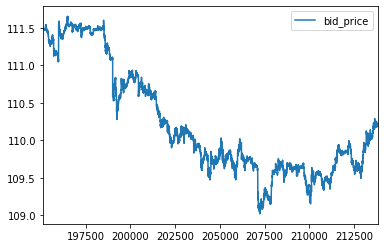

In [144]:
X_train[X_train.ccy=='usdjpy'][['bid_price']].plot()

In [150]:
X_train[X_train.ccy=='usdjpy'][['bid_price']].iloc[500:510]

,bid_price
195608,111.350
195609,111.332
195610,111.331
195611,111.341
195612,111.320
195613,111.323
195614,111.337
195615,111.336
195616,111.339
195617,111.361


In [60]:
import tensorflow as tf
from tf.keras.optimizers import Adam
from tf.keras.models import Sequential
from tf.keras.layers.core import Dense, Dropout
import random
import numpy as np
import pandas as pd
from operator import add


class DQNAgent(object):

    def __init__(self):
        self.reward = 0
        self.gamma = 0.9
        self.dataframe = pd.DataFrame()
        self.short_memory = np.array([])
        self.agent_target = 1
        self.agent_predict = 0
        self.learning_rate = 0.0005
        self.model = self.network()
        #self.model = self.network("weights.hdf5")
        self.epsilon = 0
        self.actual = []
        self.memory = []

    def get_state(self, game, player, food):

        state = [
            (player.x_change == 20 and player.y_change == 0 and ((list(map(add, player.position[-1], [20, 0])) in player.position) or
            player.position[-1][0] + 20 >= (game.game_width - 20))) or (player.x_change == -20 and player.y_change == 0 and ((list(map(add, player.position[-1], [-20, 0])) in player.position) or
            player.position[-1][0] - 20 < 20)) or (player.x_change == 0 and player.y_change == -20 and ((list(map(add, player.position[-1], [0, -20])) in player.position) or
            player.position[-1][-1] - 20 < 20)) or (player.x_change == 0 and player.y_change == 20 and ((list(map(add, player.position[-1], [0, 20])) in player.position) or
            player.position[-1][-1] + 20 >= (game.game_height-20))),  # danger straight

            (player.x_change == 0 and player.y_change == -20 and ((list(map(add,player.position[-1],[20, 0])) in player.position) or
            player.position[ -1][0] + 20 > (game.game_width-20))) or (player.x_change == 0 and player.y_change == 20 and ((list(map(add,player.position[-1],
            [-20,0])) in player.position) or player.position[-1][0] - 20 < 20)) or (player.x_change == -20 and player.y_change == 0 and ((list(map(
            add,player.position[-1],[0,-20])) in player.position) or player.position[-1][-1] - 20 < 20)) or (player.x_change == 20 and player.y_change == 0 and (
            (list(map(add,player.position[-1],[0,20])) in player.position) or player.position[-1][
             -1] + 20 >= (game.game_height-20))),  # danger right

             (player.x_change == 0 and player.y_change == 20 and ((list(map(add,player.position[-1],[20,0])) in player.position) or
             player.position[-1][0] + 20 > (game.game_width-20))) or (player.x_change == 0 and player.y_change == -20 and ((list(map(
             add, player.position[-1],[-20,0])) in player.position) or player.position[-1][0] - 20 < 20)) or (player.x_change == 20 and player.y_change == 0 and (
            (list(map(add,player.position[-1],[0,-20])) in player.position) or player.position[-1][-1] - 20 < 20)) or (
            player.x_change == -20 and player.y_change == 0 and ((list(map(add,player.position[-1],[0,20])) in player.position) or
            player.position[-1][-1] + 20 >= (game.game_height-20))), #danger left


            player.x_change == -20,  # move left
            player.x_change == 20,  # move right
            player.y_change == -20,  # move up
            player.y_change == 20,  # move down
            food.x_food < player.x,  # food left
            food.x_food > player.x,  # food right
            food.y_food < player.y,  # food up
            food.y_food > player.y  # food down
            ]

        for i in range(len(state)):
            if state[i]:
                state[i]=1
            else:
                state[i]=0

        return np.asarray(state)

    def set_reward(self, player, crash):
        self.reward = 0
        if crash:
            self.reward = -10
            return self.reward
        if player.eaten:
            self.reward = 10
        return self.reward

    def network(self, weights=None):
        model = Sequential()
        model.add(Dense(output_dim=120, activation='relu', input_dim=11))
        model.add(Dropout(0.15))
        model.add(Dense(output_dim=120, activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(output_dim=120, activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(output_dim=3, activation='softmax'))
        opt = Adam(self.learning_rate)
        model.compile(loss='mse', optimizer=opt)

        if weights:
            model.load_weights(weights)
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay_new(self, memory):
        if len(memory) > 1000:
            minibatch = random.sample(memory, 1000)
        else:
            minibatch = memory
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(np.array([next_state]))[0])
            target_f = self.model.predict(np.array([state]))
            target_f[0][np.argmax(action)] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)

    def train_short_memory(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape((1, 11)))[0])
        target_f = self.model.predict(state.reshape((1, 11)))
        target_f[0][np.argmax(action)] = target
        self.model.fit(state.reshape((1, 11)), target_f, epochs=1, verbose=0)

ModuleNotFoundError: No module named 'tf'

In [66]:
state = np.empty(11)

In [67]:
state

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [65]:
target_f = np.empty(state.reshape(1,11))

TypeError: data type not understood

In [64]:
target_f

array([[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]])

In [68]:
target_f

array([[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]])

In [70]:
target_f[0]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])